In [1]:
import skimage
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import imreg
from skimage.feature import canny
from skimage.transform import hough_circle, hough_circle_peaks, hough_ellipse
from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from stabilize_sequence import 

# WARNING: this is a mess ... just 

In [57]:
import skimage.feature

In [58]:
skimage.feature.register_translation?

In [36]:
im =tifffile.imread("C:/Users/Volker/Data/eggs_jen.tif")
im.shape
#im = im[1:,...]

(97, 1040, 1392)

In [59]:
def stabilize_getshifts(im):
    """get shifts for sequence
    
    Parameters
    ----------
    seq : numpy array time series (t, ...)
        finds the pairwise shifts
    returns np.array of shifts
    """
    shifts= map(lambda n: skimage.feature.register_translation(im[n,...], im[n+1,...], return_error=False), range(im.shape[0]-1))
    shifts=[[0,0]] + list(shifts)
    return np.array(shifts)

In [60]:
shifts = stabilize_getshifts(im)

In [33]:
def stabilize_apply_shifts(seq, shifts):
    """apply shifts to a sequence possibly with multiple channels  
    Parameters
    ----------
    seq : numpy array time series (tyx or tcyx)
        [description]
    shifts : np array as returned from stabilize_getshifts
        [description]
    """

    input_is_single_ch = False
    if seq.ndim == 3:
        seq = seq[:,np.newaxis, ...]
        input_is_single_ch = True

    cumulative_shifts=np.cumsum(shifts,axis=0)
    cummax = np.max(cumulative_shifts, axis=0)
    cummin = np.min(cumulative_shifts, axis=0)

    cumulative_shifts -= cummin
    enlarge_shape_by = cummax - cummin
    print(enlarge_shape_by)
    nt, nc, ny, nx = seq.shape
    print(seq.shape)
    padded_shape =  [nt, nc] + list(np.array([ny,nx])+enlarge_shape_by)
    padded_series = np.zeros(padded_shape, dtype=seq.dtype)
    print(f"padded {padded_series.shape}")
    for i, d in enumerate(cumulative_shifts):
        padded_series[i, 0:1, d[0]:d[0]+ny, d[1]:d[1]+nx] = seq[i,  ...]
    return padded_series

In [41]:
newim = stabilize_apply_shifts(im, shifts)

[114  19]
(97, 1, 1040, 1392)
padded (97, 1, 1154, 1411)


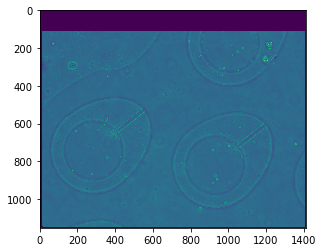

In [43]:
plt.imshow(np.median(newim[:,0,...],axis=0))

# Drift correction

In [6]:
shifts= map(lambda n: imreeg.translation(im[n,...], im[n+1,...]), range(im.shape[0]-1))
shifts=list(shifts)
allshifts=np.array(shifts)

In [12]:
minshifts=np.min(allshifts, axis=0)
maxshifts=np.max(allshifts, axis=0)

In [13]:
cumulative_shifts=np.cumsum(allshifts,axis=0)
cummax= np.max(cumulative_shifts, axis=0)
# todo: don't forget to also add negative shifts
nt, ny, nx = im.shape
padded_shape =  [nt] + list(np.array([ny,nx])+cummax)

In [14]:
padded_series = np.zeros(padded_shape, dtype=im.dtype)
padded_series.shape

(97, 1154, 1411)

In [15]:
padded_series[0, 0:ny, 0:nx] = im[0]
for i, d in enumerate(cumulative_shifts):
    padded_series[i+1, d[0]:d[0]+ny, d[1]:d[1]+nx] = im[i+1, ...]

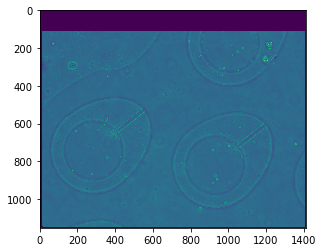

In [16]:
median_of_series = np.median(padded_series,axis=0) 
plt.imshow(median_of_series)

In [17]:
# should probably crop of regions with zeros (i.e down to the minimum in all pictures)

# some questions: counts of cells in egg chambers should somehow be normalized to density of cells

# density of cells needs to take into account the total area of the cells available for movement
# this requires masking out all areas where cells cannot move (different in different images)

In [48]:

def stabilize_crop_to_overlap(seq):
    tmp = np.where(np.min(seq, axis=0)>0)
    miny, maxy = np.min(tmp[-2]),np.max(tmp[-2])
    minx, maxx = np.min(tmp[-1]),np.max(tmp[-1])
    cropped = seq[..., miny:maxy, minx:maxx]
    return cropped

In [49]:
cropped = stabilize_crop_to_overlap(newim)

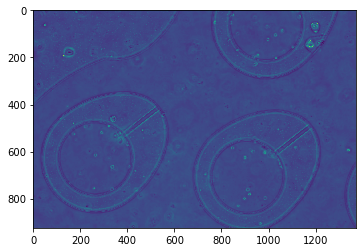

In [51]:
plt.imshow(np.median(cropped[:,0,...],axis=0))

In [52]:
imreg.translation?

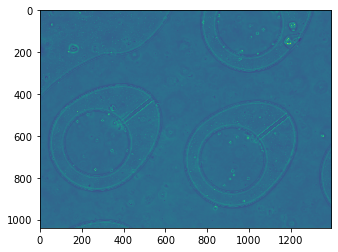

In [18]:
tmp = np.where(median_of_series>0)
miny, maxy = np.min(tmp[0]),np.max(tmp[0])
minx, maxx = np.min(tmp[1]),np.max(tmp[1])
cropped = median_of_series[miny:maxy, minx:maxx]
plt.imshow(cropped)

In [19]:
def dog(im, g1=5, g2=3, abs=False):
    dog = skimage.filters.gaussian(im, g1)-skimage.filters.gaussian(im, g2)
    if abs:
        return np.abs(dog)
    return dog

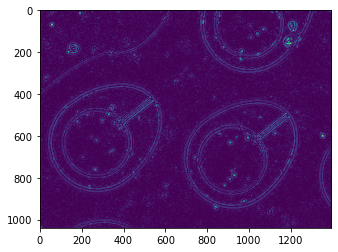

In [20]:
gradient = dog(cropped, 6, 3,abs=True)
plt.imshow(gradient)

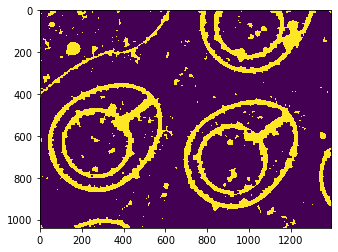

In [21]:
thresh = skimage.filters.threshold_otsu(gradient)
borders = gradient > thresh
borders = skimage.morphology.closing(borders, skimage.morphology.square(10))
#borders = skimage.morphology.skeletonize(borders)
plt.imshow(borders)

In [22]:
radii=np.arange(120, 170, 5)
res = hough_circle(borders, radius=radii)

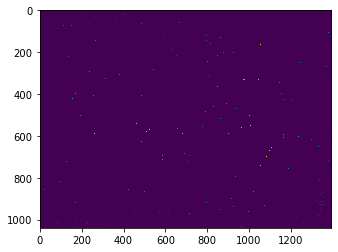

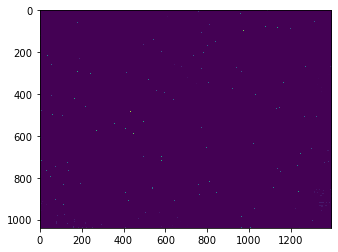

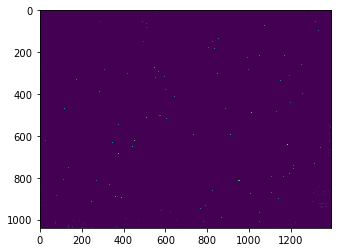

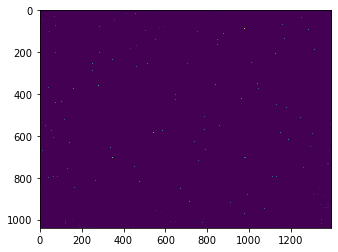

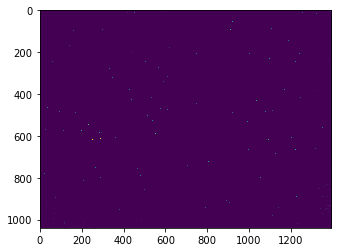

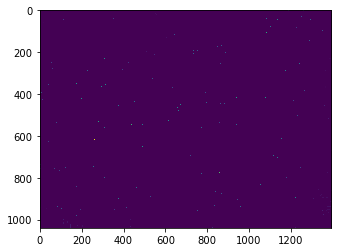

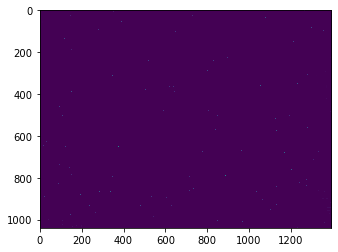

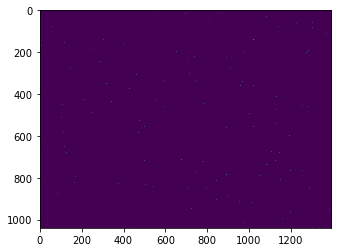

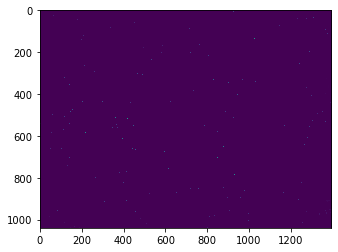

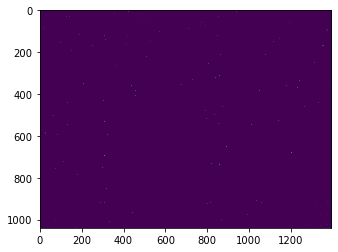

In [60]:
for i in range(res.shape[0]):
    plt.imshow(newres[i,...])
    plt.show()


In [24]:
res.max()

1.0000000000000093

In [62]:
accums, cx, cy, radii = hough_circle_peaks(newres, radii, min_xdistance=300, 
                                           min_ydistance=300)

In [63]:
accums, cx, cy, radii

(array([1.        , 1.        , 1.        , 0.98717949, 0.98026316,
        0.9661215 , 0.95227273, 0.94859813, 0.67640187, 0.675     ,
        0.65789474, 0.64102564, 0.63713592, 0.63592233, 0.6025    ,
        0.56917476, 0.565     , 0.5625    , 0.54069767, 0.53897849,
        0.53511236, 0.53343023, 0.52553763, 0.5238764 , 0.52213542,
        0.52125   , 0.5188172 , 0.51171875, 0.50290698, 0.50280899]),
 array([ 270,  271,  270,  916,  918,  269,  915,  916,  995,  996,  996,
         994,  920,  258,  282, 1001,  895,  292,  313,  297, 1100, 1104,
         815,  312,  892, 1056, 1078, 1066, 1082, 1080]),
 array([638, 634, 630, 712, 717, 635, 718, 713,  79,  76,  71,  65, 732,
        644, 659,  86, 694, 656, 653, 658, 584, 579, 716, 647, 690, 138,
        133, 137, 143, 130]),
 array([155, 150, 155, 150, 155, 150, 155, 150, 150, 155, 155, 150, 155,
        155, 150, 155, 150, 155, 150, 150, 155, 150, 150, 155, 155, 150,
        150, 155, 150, 155]))

In [29]:
accums

array([1.        , 1.        , 1.        , 0.98717949, 0.98026316,
       0.9661215 , 0.95227273, 0.94859813, 0.67640187, 0.675     ,
       0.65789474, 0.64102564, 0.63713592, 0.63592233, 0.6025    ,
       0.56917476, 0.565     , 0.5625    , 0.54069767, 0.53897849,
       0.53511236, 0.53343023, 0.52553763, 0.5238764 , 0.52213542,
       0.52125   , 0.5188172 , 0.51171875, 0.50290698, 0.50280899])

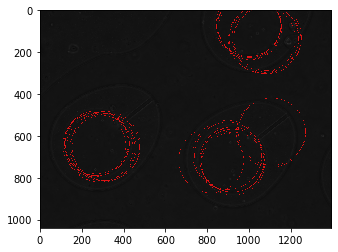

In [61]:

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(img_as_ubyte(cropped.astype(np.uint16)*10))

for accum, center_y, center_x, radius in zip(accums, cy, cx, radii):
    if accum > 0.0:
        circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
        image[circy, circx] = (220, 20, 20)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

In [40]:
import skimage.morphology

In [59]:
dilres=res.copy()
for i in range(dilres.shape[0]):
    dilres[i]=skimage.morphology.dilation(res[i], skimage.morphology.disk(30))

In [53]:
same = dilres == res
newres = res * same

In [61]:
import cv2
import numpy as np
    
#img = cv2.imread('opencv_logo.png',0)
#img = cv2.medianBlur(img,5)
#cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
tmp = borders*128
circles = cv2.HoughCircles(gradient.astype(np.uint8),cv2.HOUGH_GRADIENT,1, 350, param1=30, param2=30,minRadius=130,maxRadius=170)


NameError: name 'borders' is not defined

In [44]:
circles


array([[[272.5, 634.5, 169.4],
        [916.5, 713.5, 160.6],
        [994.5,  65.5, 167.2]]], dtype=float32)

In [124]:
cv2.HoughCircles?

In [46]:
cimg = cv2.cvtColor(gradient.astype(np.uint8),cv2.COLOR_GRAY2BGR)

In [47]:
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
     # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

In [127]:
#cv2.imshow('detected circles',cimg)

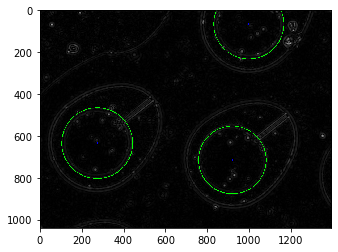

In [48]:
plt.imshow(cimg)

In [162]:
circles

array([[[272, 634, 169],
        [916, 714, 161],
        [994,  66, 167]]], dtype=uint16)

In [62]:
cv2.HoughCircles?

In [129]:
hough_circle_peaks?

In [158]:
smooth_res = skimage.filters.gaussian(res,sigma=10)

In [ ]:
import cv2